In [2]:
# Cell 1: Imports and device check

import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Check PyTorch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [4]:
# Cell 2: Load features + Monte Carlo Q-values from .h5

h5_path = r"D:\SFTP\Data\featuresMedium.h5"

with h5py.File(h5_path, "r") as f:
    # List all top‐level groups/datasets
    print("Top‐level keys in HDF5:", list(f.keys()))

    # Read entire "features" dataset into memory
    X = f["features"][:]             # shape = (N_samples, D_features)
    y_MC = f["q_values"][:]          # shape = (N_samples,)

print(f"Loaded X.shape = {X.shape}, y_MC.shape = {y_MC.shape}")


Top‐level keys in HDF5: ['features', 'game_ids', 'q_values']
Loaded X.shape = (1753063, 138), y_MC.shape = (1753063,)


In [5]:
# Cell 3: Split into train/validation and scale

# 1) Train/test split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_MC, test_size=0.20, random_state=42, shuffle=True
)

print("After split:")
print(f"  X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"  X_val.shape   = {X_val.shape},   y_val.shape   = {y_val.shape}")

# 2) (Optional) Standardize features if they aren't already zero‐centered
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)


# 3) Check a quick stats summary
print("\nFeature means (first 5 dims before scaling) on training set:", X_train[:, :5].mean(axis=0))
print("Feature std  (first 5 dims before scaling) on training set:", X_train[:, :5].std(axis=0))

# 3) Check a quick stats summary
print("\nFeature means (first 5 dims) on training set:", X_train_scaled[:, :5].mean(axis=0))
print("Feature std  (first 5 dims) on training set:", X_train_scaled[:, :5].std(axis=0))


After split:
  X_train.shape = (1402450, 138), y_train.shape = (1402450,)
  X_val.shape   = (350613, 138),   y_val.shape   = (350613,)

Feature means (first 5 dims before scaling) on training set: [-0.08488645 -0.07769831 -0.07860316 -0.07839067 -0.06409212]
Feature std  (first 5 dims before scaling) on training set: [0.68805134 0.54813814 0.552993   0.58522856 0.985578  ]

Feature means (first 5 dims) on training set: [ 2.6825912e-06  5.1035668e-06 -2.8754562e-06  2.1174327e-07
  8.1256093e-07]
Feature std  (first 5 dims) on training set: [0.9950252 0.9952313 0.9954259 0.9965159 0.9983205]


In [6]:
# Cell 4: Build PyTorch Dataset + DataLoader

from torch.utils.data import TensorDataset, DataLoader

# Convert NumPy → torch.Tensor (float32)
X_train_t = torch.from_numpy(X_train_scaled).float().to(device)
y_train_t = torch.from_numpy(y_train).float().to(device)
X_val_t   = torch.from_numpy(X_val_scaled).float().to(device)
y_val_t   = torch.from_numpy(y_val).float().to(device)

# Create TensorDataset
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t, y_val_t)

# DataLoader params
batch_size = 512

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,      # set to 0 if Windows + Jupyter stall
    pin_memory=True if device.type=="cuda" else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True if device.type=="cuda" else False
)

print(f"Created train_loader (batches of {batch_size}), val_loader likewise.")


Created train_loader (batches of 512), val_loader likewise.


In [7]:
# Cell 5 (v2): Deeper Q-Network with tanh

import torch.nn as nn

class QNetwork(nn.Module):
    def __init__(self, input_dim: int, hidden_sizes=(256, 128, 64, 32, 16, 8)):
        super().__init__()
        layers = []
        last_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.Tanh())
            last_dim = h
        # Final output layer → tanh bounded in [-1,1]
        layers.append(nn.Linear(last_dim, 1))
        layers.append(nn.Tanh())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

# Re‐instantiate model
input_dim = X_train_t.shape[1]
model = QNetwork(input_dim=input_dim, hidden_sizes=(256, 128, 64, 32, 16, 8)).to(device)
print(model)


QNetwork(
  (net): Sequential(
    (0): Linear(in_features=138, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): Tanh()
    (10): Linear(in_features=16, out_features=8, bias=True)
    (11): Tanh()
    (12): Linear(in_features=8, out_features=1, bias=True)
    (13): Tanh()
  )
)


In [8]:
# Cell 6 (v2): Optimizer & loss function (smaller lr)

lr = 5e-4      # down from 1e-3 since network is larger
num_epochs = 20  # you can still cap at 20 and use early stopping

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.MSELoss()

print(f"Learning rate = {lr}, Number of epochs = {num_epochs}")


Learning rate = 0.0005, Number of epochs = 20


In [9]:
# Cell 7: MC Pretraining loop

best_val_loss = float("inf")

for epoch in range(1, num_epochs + 1):
    # ---------- Training pass ----------
    model.train()
    running_train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        # Forward pass: predict Q̂
        preds = model(batch_X)             # shape: (batch_size,)
        loss = criterion(preds, batch_y)   # MSE against MC targets
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * batch_X.size(0)

    avg_train_loss = running_train_loss / len(train_loader.dataset)

    # ---------- Validation pass ----------
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            preds = model(batch_X)
            loss = criterion(preds, batch_y)
            running_val_loss += loss.item() * batch_X.size(0)

    avg_val_loss = running_val_loss / len(val_loader.dataset)

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {avg_train_loss:.6f} | "
        f" Val Loss: {avg_val_loss:.6f}"
    )

    # Save best‐performing weights on validation
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "qnet_mc_pretrained.pth")
        print("  → Saved new best model (MC pretrained)")


Epoch 01 | Train Loss: 0.394465 |  Val Loss: 0.377738
  → Saved new best model (MC pretrained)
Epoch 02 | Train Loss: 0.365932 |  Val Loss: 0.358084
  → Saved new best model (MC pretrained)
Epoch 03 | Train Loss: 0.353425 |  Val Loss: 0.351917
  → Saved new best model (MC pretrained)
Epoch 04 | Train Loss: 0.344792 |  Val Loss: 0.351785
  → Saved new best model (MC pretrained)
Epoch 05 | Train Loss: 0.338311 |  Val Loss: 0.349326
  → Saved new best model (MC pretrained)
Epoch 06 | Train Loss: 0.332839 |  Val Loss: 0.338984
  → Saved new best model (MC pretrained)
Epoch 07 | Train Loss: 0.327749 |  Val Loss: 0.338211
  → Saved new best model (MC pretrained)
Epoch 08 | Train Loss: 0.323538 |  Val Loss: 0.336096
  → Saved new best model (MC pretrained)
Epoch 09 | Train Loss: 0.319787 |  Val Loss: 0.331689
  → Saved new best model (MC pretrained)
Epoch 10 | Train Loss: 0.316217 |  Val Loss: 0.329008
  → Saved new best model (MC pretrained)
Epoch 11 | Train Loss: 0.313155 |  Val Loss: 0.328

C:\Users\Owner\AppData\Local\Temp\ipykernel_1628\799107061.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("qnet_mc_pretrained.pth"))


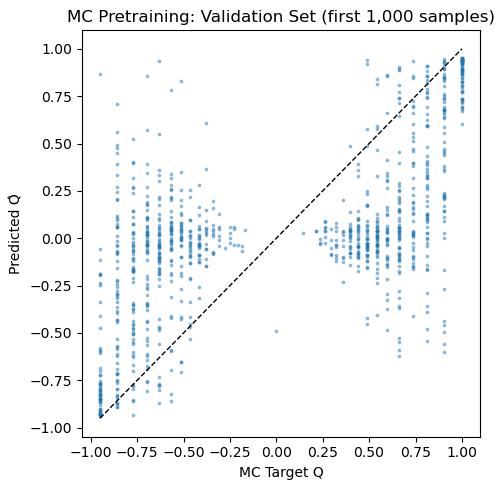

In [10]:
# Cell 8: Plot predicted vs. true MC targets for a sample of the validation set

import matplotlib.pyplot as plt

# 1) Reload best MC‐pretrained weights
model.load_state_dict(torch.load("qnet_mc_pretrained.pth"))
model.eval()

# 2) Gather all predictions on the val set
all_preds = []
all_targets = []
with torch.no_grad():
    for batch_X, batch_y in val_loader:
        pred_vals = model(batch_X).cpu().numpy()
        all_preds.append(pred_vals)
        all_targets.append(batch_y.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# 3) Plot the first 1,000 points
n_plot = min(1000, len(all_preds))
plt.figure(figsize=(5,5))
plt.scatter(
    all_targets[:n_plot],
    all_preds[:n_plot],
    s=3, alpha=0.4, color="tab:blue"
)
plt.plot([all_targets.min(), all_targets.max()],
         [all_targets.min(), all_targets.max()],
         color="black", linestyle="--", linewidth=1)
plt.xlabel("MC Target Q")
plt.ylabel("Predicted Q̂")
plt.title("MC Pretraining: Validation Set (first 1,000 samples)")
plt.tight_layout()
plt.show()
